# Matrix Factorization (MF) Recommender Example
Demonstrates matrix factorization with MXNet on the [MovieLens 100k](http://grouplens.org/datasets/movielens/100k/) dataset. We perform **collaborative filtering**, where the recommendations are based on previous rating of users.

We are trying to learn embeddings for users and movies, based on user partial ratings of movies, to estimate future movie ratings

![](https://i.imgur.com/twyWChh.png)


For more deep learning based architecture for recommendation, refer to this survey: [Deep Learning based Recommender System: A Survey and New Perspectives](https://arxiv.org/pdf/1707.07435.pdf)

In [1]:
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np

from matrix_fact import train
from movielens_data import get_dataset, max_id

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


### Config

In [2]:
ctx = [mx.gpu(0)] if len(mx.test_utils.list_gpus()) > 0 else [mx.cpu()]
batch_size = 128

## Data

In [3]:
train_dataset, test_dataset = get_dataset()
max_user, max_item = max_id('./ml-100k/u.data')
(max_user, max_item)

(944, 1683)

In [4]:
train_data = gluon.data.DataLoader(train_dataset, shuffle=True, last_batch='rollover', batch_size=batch_size, num_workers=0)
test_data = gluon.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=0)

In [5]:
for user, item, score in test_data:
    print(user[0], item[0], score[0])
    break


[38.]
<NDArray 1 @cpu(0)> 
[508.]
<NDArray 1 @cpu(0)> 
[2.]
<NDArray 1 @cpu(0)>


## Linear Matrix Factorization

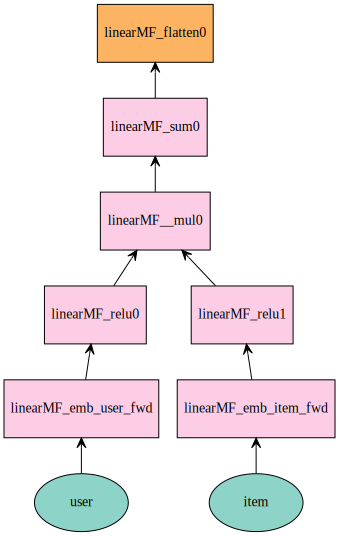

In [6]:
class LinearMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k, max_user=max_user, max_item=max_item):
        super(LinearMatrixFactorization, self).__init__(prefix='linearMF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_') 

            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_') 
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user).relu()
        items_embeddings = self.item_embedding(item).relu()
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_embeddings * items_embeddings).sum(axis=1)
        
        return pred.flatten()

net1 = LinearMatrixFactorization(64)
net1.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net1(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [7]:
net1.summary(user.as_in_context(ctx[0]), item.as_in_context(ctx[0]))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (128,), (128,)               0
         Embedding-1                                   (128, 64)           60416
         Embedding-2                                   (128, 64)          107712
LinearMatrixFactorization-3                                    (128, 1)               0
Parameters in forward computation graph, duplicate included
   Total params: 168128
   Trainable params: 168128
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 168128
--------------------------------------------------------------------------------


In [8]:
losses_1 = train(net1, train_data, test_data, epochs=15, learning_rate=1, ctx=ctx)

Epoch [0], Training RMSE 6.1854, Test RMSE 5.2134
Epoch [1], Training RMSE 2.9043, Test RMSE 2.1358
Epoch [2], Training RMSE 1.3456, Test RMSE 1.3472
Epoch [3], Training RMSE 0.9293, Test RMSE 1.0726


INFO:root:Update[3126]: Change learning rate to 2.00000e-01


Epoch [4], Training RMSE 0.7585, Test RMSE 0.9467
Epoch [5], Training RMSE 0.6742, Test RMSE 0.9301
Epoch [6], Training RMSE 0.6587, Test RMSE 0.9139
Epoch [7], Training RMSE 0.6449, Test RMSE 0.9023
Epoch [8], Training RMSE 0.6324, Test RMSE 0.8886


INFO:root:Update[6251]: Change learning rate to 4.00000e-02


Epoch [9], Training RMSE 0.6210, Test RMSE 0.8793
Epoch [10], Training RMSE 0.6100, Test RMSE 0.8764
Epoch [11], Training RMSE 0.6080, Test RMSE 0.8744
Epoch [12], Training RMSE 0.6059, Test RMSE 0.8747
Epoch [13], Training RMSE 0.6039, Test RMSE 0.8717
Epoch [14], Training RMSE 0.6020, Test RMSE 0.8688


In [9]:
losses_1

[(6.185443237304687, 5.213418274168756),
 (2.9042590438842772, 2.1358377728492592),
 (1.345566930294037, 1.347152523554055),
 (0.9292820259094239, 1.0726493737500185),
 (0.7584892754554748, 0.9466582980884868),
 (0.6742267098426818, 0.9300613839914844),
 (0.6587229638576507, 0.9138735935186885),
 (0.6448600271701813, 0.9023025612922231),
 (0.632410079240799, 0.8885752661212994),
 (0.6209696002960206, 0.8793287337965267),
 (0.6100408156871796, 0.8763645693754695),
 (0.6079610646724701, 0.8743740775782591),
 (0.6059287497997284, 0.8747020732065675),
 (0.6039103961467743, 0.8717364558748378),
 (0.6019688241481781, 0.8687770996883417)]

The optimizer used for training and hyper-parameter influence greatly how fast the model converge.
We can try with the [Adam optimizer](https://arxiv.org/abs/1412.6980) which will often converge much faster than SGD without momentum as we used before.  You should see this model over-fitting quickly. 

In [10]:
net1 = LinearMatrixFactorization(64)
net1.initialize(mx.init.Xavier(), ctx=ctx)

In [11]:
losses_1_adam = train(net1, train_data, test_data, epochs=15, optimizer='adam', learning_rate=0.01, ctx=ctx)

Epoch [0], Training RMSE 1.2345, Test RMSE 0.7134
Epoch [1], Training RMSE 0.6484, Test RMSE 0.6597
Epoch [2], Training RMSE 0.5852, Test RMSE 0.6618
Epoch [3], Training RMSE 0.5195, Test RMSE 0.5936


INFO:root:Update[3126]: Change learning rate to 2.00000e-03


Epoch [4], Training RMSE 0.4531, Test RMSE 0.5900
Epoch [5], Training RMSE 0.2978, Test RMSE 0.4903
Epoch [6], Training RMSE 0.2770, Test RMSE 0.4891
Epoch [7], Training RMSE 0.2710, Test RMSE 0.4920
Epoch [8], Training RMSE 0.2654, Test RMSE 0.4949


INFO:root:Update[6251]: Change learning rate to 4.00000e-04


Epoch [9], Training RMSE 0.2613, Test RMSE 0.4922
Epoch [10], Training RMSE 0.2311, Test RMSE 0.4868
Epoch [11], Training RMSE 0.2284, Test RMSE 0.4876
Epoch [12], Training RMSE 0.2278, Test RMSE 0.4886
Epoch [13], Training RMSE 0.2274, Test RMSE 0.4898
Epoch [14], Training RMSE 0.2272, Test RMSE 0.4899


### Visualizing embeddings

In [12]:
ratings = nd.dot(net1.user_embedding.weight.data(ctx=ctx[0]), net1.item_embedding.weight.data(ctx=ctx[0]).T).asnumpy()
ratings.shape

(944, 1683)

In [13]:
# Helper function to print the recommendation matrix
# And the top 5 movies in several categories

def evaluate_embeddings(ratings):
    plt.figure(figsize=(15,15))
    plt.xlabel('items')
    plt.ylabel('users')
    plt.title('Users estimated ratings of items sorted by mean ratings across users')
    im = plt.imshow(((ratings[:, ratings.mean(axis=0).argsort()[::-1]])))
    cb = plt.colorbar(im,fraction=0.026, pad=0.04, label="score")
    
    top_5_movies = ratings.mean(axis=0).argsort()[::-1][:5] # Highest mean projected rating
    worst_5_movies = ratings.mean(axis=0).argsort()[:5] # Lowest mean projected rating
    top_5_controversial = ratings.std(axis=0).argsort()[::-1][:5] # With most variance
    
    with open('ml-100k/u.item', 'rb') as f:
        movies = f.readlines()
        
    print("Top 5 movies:")
    for movie in top_5_movies:
        print("{}, average rating {:.2f}".format(str(movies[int(movie)-1]).split("|")[1], ratings.mean(axis=0)[movie]))
    print("\nWorst 5 movies:")
    for movie in worst_5_movies:
        print("{}, average rating {:.2f}".format(str(movies[int(movie)-1]).split("|")[1], ratings.mean(axis=0)[movie]))
    print("\n5 most controversial movies:")
    for movie in top_5_controversial:
        print("{}, average rating {:.2f}".format(str(movies[int(movie)-1]).split("|")[1], ratings.mean(axis=0)[movie]))

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


Top 5 movies:
Schindler's List (1993), average rating 4.18
L.A. Confidential (1997), average rating 4.16
Star Wars (1977), average rating 4.16
Titanic (1997), average rating 4.15
Shawshank Redemption, The (1994), average rating 4.13

Worst 5 movies:
Homage (1995), average rating -0.00
Bird of Prey (1996), average rating -0.00
Promise, The (Versprechen, Das) (1994), average rating -0.00
Fear, The (1995), average rating -0.00
Window to Paris (1994), average rating -0.00

5 most controversial movies:
Pulp Fiction (1994), average rating 3.68
Independence Day (ID4) (1996), average rating 3.15
Clockwork Orange, A (1971), average rating 3.29
Big Night (1996), average rating 3.27
Apocalypse Now (1979), average rating 3.54


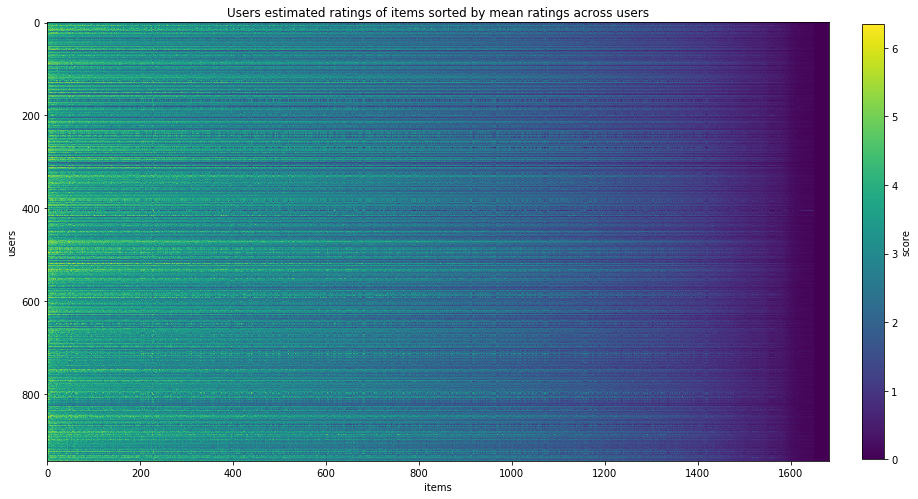

In [14]:
evaluate_embeddings(ratings)

We can observe that some movies tend to be widely recommended or not recommended, whilst some other have more variance in their predicted score

## Neural Network (non-linear) Matrix Factorization

We don't have to limit ourselves to the weights of the linear embedding layer for our user or item embeddings. We can have a more complex pipeline combining fully connected layers and non-linear activations.

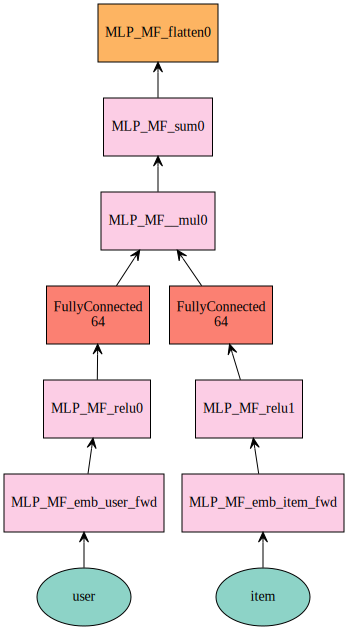

In [15]:
class MLPMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k, hidden, max_user=max_user, max_item=max_item):
        super(MLPMatrixFactorization, self).__init__(prefix='MLP_MF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_') 
            self.user_mlp = gluon.nn.Dense(hidden, prefix='dense_user_')

            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_') 
            self.item_mlp = gluon.nn.Dense(hidden, prefix='dense_item_')
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user)
        user_embeddings_relu = user_embeddings.relu()
        user_transformed = self.user_mlp(user_embeddings_relu)
        
        items_embeddings = self.item_embedding(item)
        items_embeddings_relu = items_embeddings.relu()
        items_transformed = self.item_mlp(items_embeddings_relu)
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_transformed * items_transformed).sum(axis=1)
        
        return pred.flatten()

net2 = MLPMatrixFactorization(64, 64)
net2.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net2(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [16]:
net2.summary(user.as_in_context(ctx[0]), item.as_in_context(ctx[0]))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (128,), (128,)               0
         Embedding-1                                   (128, 64)           60416
             Dense-2                                   (128, 64)            4160
         Embedding-3                                   (128, 64)          107712
             Dense-4                                   (128, 64)            4160
MLPMatrixFactorization-5                                    (128, 1)               0
Parameters in forward computation graph, duplicate included
   Total params: 176448
   Trainable params: 176448
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 176448
--------------------------------------------------------------------------------


In [17]:
losses_2 = train(net2, train_data, test_data, epochs=15, ctx=ctx)

Epoch [0], Training RMSE 1.3127, Test RMSE 0.6534
Epoch [1], Training RMSE 0.6074, Test RMSE 0.6405
Epoch [2], Training RMSE 0.5929, Test RMSE 0.6255
Epoch [3], Training RMSE 0.5789, Test RMSE 0.6122


INFO:root:Update[3126]: Change learning rate to 2.00000e-03


Epoch [4], Training RMSE 0.5650, Test RMSE 0.6006
Epoch [5], Training RMSE 0.5560, Test RMSE 0.5965
Epoch [6], Training RMSE 0.5532, Test RMSE 0.5929
Epoch [7], Training RMSE 0.5504, Test RMSE 0.5914
Epoch [8], Training RMSE 0.5476, Test RMSE 0.5893


INFO:root:Update[6251]: Change learning rate to 4.00000e-04


Epoch [9], Training RMSE 0.5448, Test RMSE 0.5856
Epoch [10], Training RMSE 0.5431, Test RMSE 0.5855
Epoch [11], Training RMSE 0.5425, Test RMSE 0.5856
Epoch [12], Training RMSE 0.5420, Test RMSE 0.5846
Epoch [13], Training RMSE 0.5414, Test RMSE 0.5833
Epoch [14], Training RMSE 0.5409, Test RMSE 0.5822


We can try training with the Adam optimizer instead

In [18]:
net2 = MLPMatrixFactorization(64, 64)
net2.initialize(mx.init.Xavier(), ctx=ctx)

In [19]:
losses_2_adam  = train(net2, train_data, test_data, epochs=15, optimizer='adam', learning_rate=0.01, ctx=ctx)

Epoch [0], Training RMSE 0.6292, Test RMSE 0.4896
Epoch [1], Training RMSE 0.4623, Test RMSE 0.4818
Epoch [2], Training RMSE 0.4539, Test RMSE 0.4811
Epoch [3], Training RMSE 0.4486, Test RMSE 0.5017


INFO:root:Update[3126]: Change learning rate to 2.00000e-03


Epoch [4], Training RMSE 0.4462, Test RMSE 0.4950
Epoch [5], Training RMSE 0.4144, Test RMSE 0.4506
Epoch [6], Training RMSE 0.4054, Test RMSE 0.4489
Epoch [7], Training RMSE 0.4026, Test RMSE 0.4497
Epoch [8], Training RMSE 0.4013, Test RMSE 0.4503


INFO:root:Update[6251]: Change learning rate to 4.00000e-04


Epoch [9], Training RMSE 0.3997, Test RMSE 0.4504
Epoch [10], Training RMSE 0.3912, Test RMSE 0.4476
Epoch [11], Training RMSE 0.3898, Test RMSE 0.4466
Epoch [12], Training RMSE 0.3892, Test RMSE 0.4470
Epoch [13], Training RMSE 0.3889, Test RMSE 0.4472
Epoch [14], Training RMSE 0.3885, Test RMSE 0.4458


## Deep Neural Network (Residual Network / ResNet)
Borrowing ideas from [Deep Residual Learning for Image Recognition (He, et al.)](https://arxiv.org/abs/1512.03385) to build a complex deep network that is aggressively regularized, thanks to the dropout layers, to avoid over-fitting, but still achieves good performance. 

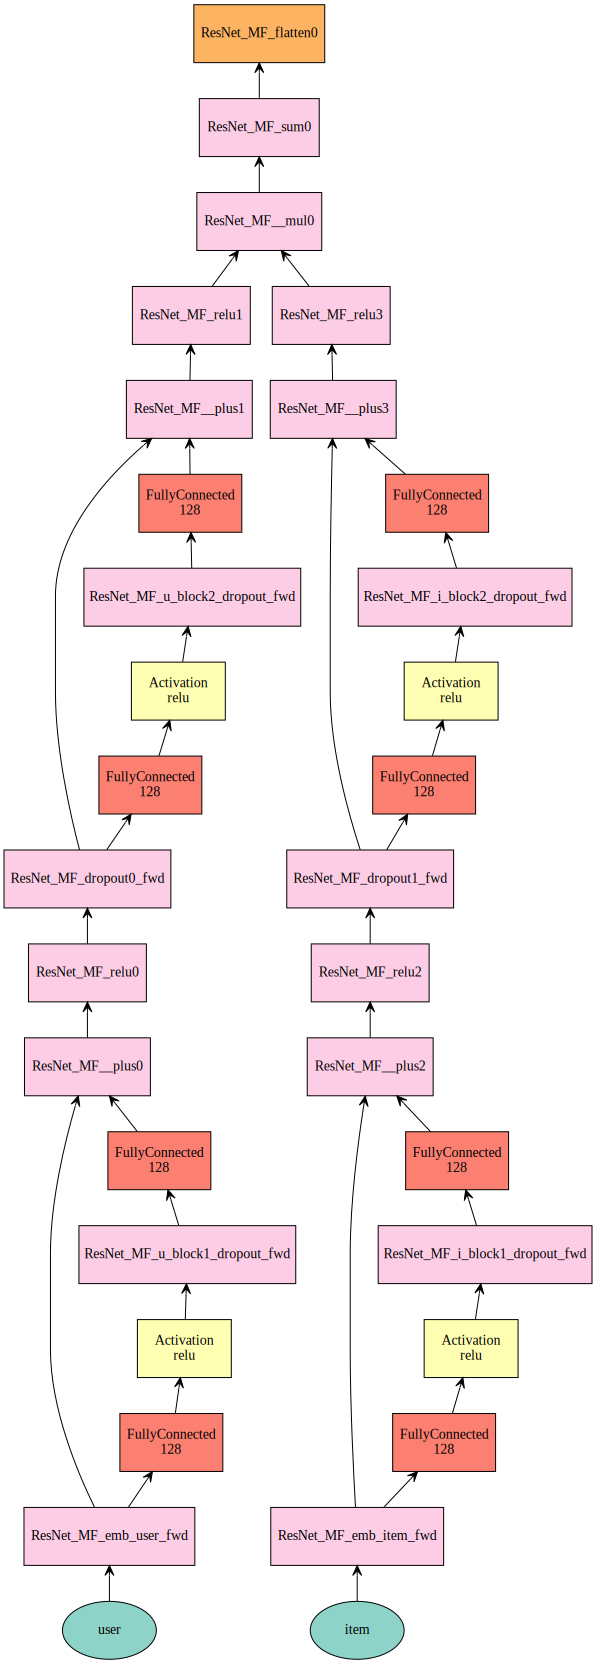

In [20]:
def get_residual_block(prefix='res_block_', hidden=64):
    block = gluon.nn.HybridSequential(prefix=prefix)
    with block.name_scope():
        block.add(
            gluon.nn.Dense(hidden, activation='relu', prefix='d1_'),
            gluon.nn.Dropout(0.5, prefix='dropout_'),
            gluon.nn.Dense(hidden, prefix='d2_')
        )
    return block
    
class ResNetMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k, hidden, max_user=max_user, max_item=max_item):
        super(ResNetMatrixFactorization, self).__init__(prefix='ResNet_MF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_')
            self.user_block1 = get_residual_block('u_block1_', hidden)
            self.user_dropout = gluon.nn.Dropout(0.5)
            self.user_block2 = get_residual_block('u_block2_', hidden)           
            
            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_')
            self.item_block1 = get_residual_block('i_block1_', hidden)
            self.item_dropout = gluon.nn.Dropout(0.5)
            self.item_block2 = get_residual_block('i_block2_', hidden)           
            
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user)
        user_block1 = self.user_block1(user_embeddings)
        user1 = (user_embeddings + user_block1).relu()
        
        user2 = self.user_dropout(user1)
        user_block2 = self.user_block2(user2)
        user_transformed = (user2 + user_block2).relu()
        
        item_embeddings = self.item_embedding(item)
        item_block1 = self.item_block1(item_embeddings)
        item1 = (item_embeddings + item_block1).relu()
        
        item2 = self.item_dropout(item1)
        item_block2 = self.item_block2(item2)
        item_transformed = (item2 + item_block2).relu()
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_transformed * item_transformed).sum(axis=1)
        
        return pred.flatten()

net3 = ResNetMatrixFactorization(128, 128)
net3.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net3(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [21]:
net3.summary(user.as_in_context(ctx[0]), item.as_in_context(ctx[0]))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (128,), (128,)               0
         Embedding-1                                  (128, 128)          120832
        Activation-2     <Symbol ResNet_MF_u_block1_d1_relu_fwd>               0
        Activation-3                                  (128, 128)               0
             Dense-4                                  (128, 128)           16512
           Dropout-5                                  (128, 128)               0
             Dense-6                                  (128, 128)           16512
           Dropout-7                                  (128, 128)               0
        Activation-8     <Symbol ResNet_MF_u_block2_d1_relu_fwd>               0
        Activation-9                                  (128, 128)               0
            Dense-10        

In [22]:
losses_3  = train(net3, train_data, test_data, epochs=15, optimizer='adam', learning_rate=0.001, ctx=ctx, num_epoch_lr=10)

Epoch [0], Training RMSE 0.7046, Test RMSE 0.6775
Epoch [1], Training RMSE 0.4861, Test RMSE 0.5299
Epoch [2], Training RMSE 0.4662, Test RMSE 0.4835
Epoch [3], Training RMSE 0.4567, Test RMSE 0.4819
Epoch [4], Training RMSE 0.4505, Test RMSE 0.4653
Epoch [5], Training RMSE 0.4491, Test RMSE 0.4582
Epoch [6], Training RMSE 0.4427, Test RMSE 0.4555
Epoch [7], Training RMSE 0.4405, Test RMSE 0.4524
Epoch [8], Training RMSE 0.4360, Test RMSE 0.4507


INFO:root:Update[6251]: Change learning rate to 2.00000e-04


Epoch [9], Training RMSE 0.4328, Test RMSE 0.4504
Epoch [10], Training RMSE 0.4172, Test RMSE 0.4442
Epoch [11], Training RMSE 0.4141, Test RMSE 0.4426
Epoch [12], Training RMSE 0.4114, Test RMSE 0.4416
Epoch [13], Training RMSE 0.4106, Test RMSE 0.4413
Epoch [14], Training RMSE 0.4095, Test RMSE 0.4390


### Visualizing embeddings

Contrary to the linear model where we can use directly the embedding weights, here we compute each combination of user / items and store predicted rating.

In [23]:
%%time

users = []
items = []
for i in range(max_user):
    for j in range(max_item):
        users.append(i+1)
        items.append(j+1)
dataset = gluon.data.ArrayDataset(np.array(users).astype('float32'), np.array(items).astype('float32'))
dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
ratings = np.zeros((max_user+1, max_item+1))
for users, items in dataloader:
    users = users.as_in_context(ctx[0])
    items = items.as_in_context(ctx[0])
    scores = net3(users, items).asnumpy()
    ratings[users.asnumpy().astype('int32'), items.asnumpy().astype('int32')] = scores.reshape(-1)

CPU times: user 26.6 s, sys: 5.26 s, total: 31.9 s
Wall time: 26 s


Top 5 movies:
Schindler's List (1993), average rating 4.43
Casablanca (1942), average rating 4.39
Wrong Trousers, The (1993), average rating 4.39
Shawshank Redemption, The (1994), average rating 4.36
Close Shave, A (1995), average rating 4.34

Worst 5 movies:
Scream of Stone (Schrei aus Stein) (1991), average rating 0.00
Mortal Kombat: Annihilation (1997), average rating 2.25
Home Alone 3 (1997), average rating 2.25
Crow: City of Angels, The (1996), average rating 2.25
Children of the Corn: The Gathering (1996), average rating 2.25

5 most controversial movies:
First Knight (1995), average rating 2.95
Half Baked (1998), average rating 2.85
Just Cause (1995), average rating 2.96
Murder at 1600 (1997), average rating 3.07
Twister (1996), average rating 3.08


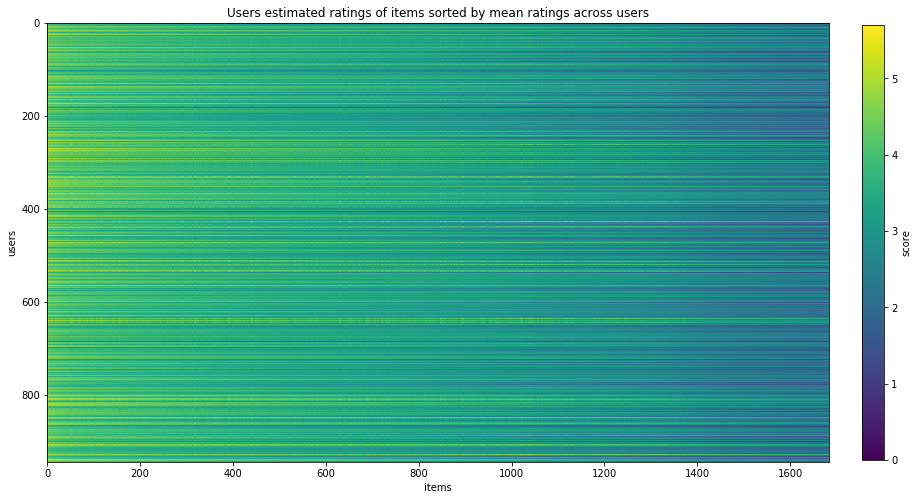

In [24]:
evaluate_embeddings(ratings)

## Visualizing training
Now let's draw a single chart that compares the learning curves of the two different models.

In [25]:
train_1,  test_1  = list(zip(*losses_1))
train_1a, test_1a = list(zip(*losses_1_adam))
train_2,  test_2  = list(zip(*losses_2))
train_2a, test_2a = list(zip(*losses_2_adam))
train_3a, test_3a = list(zip(*losses_3))

In [26]:
losses_1_adam

[(1.2344593836784363, 0.713362567743678),
 (0.648405224943161, 0.6597177934874395),
 (0.5851686426639557, 0.6617723923579902),
 (0.5194843295574189, 0.5935856424699164),
 (0.45305402550697327, 0.5900366710629433),
 (0.2977709783792496, 0.49029243049348237),
 (0.27699643795490264, 0.4890738264390617),
 (0.2709969203948975, 0.4920012930016609),
 (0.2653717215538025, 0.4948571656539941),
 (0.26125567021369933, 0.4921688241943432),
 (0.23106717193126677, 0.48678314078385665),
 (0.22838653769493103, 0.4875897347547446),
 (0.22782497510910035, 0.4886196310732775),
 (0.22744231758117675, 0.48978534644576394),
 (0.227169718003273, 0.48986973580281445)]

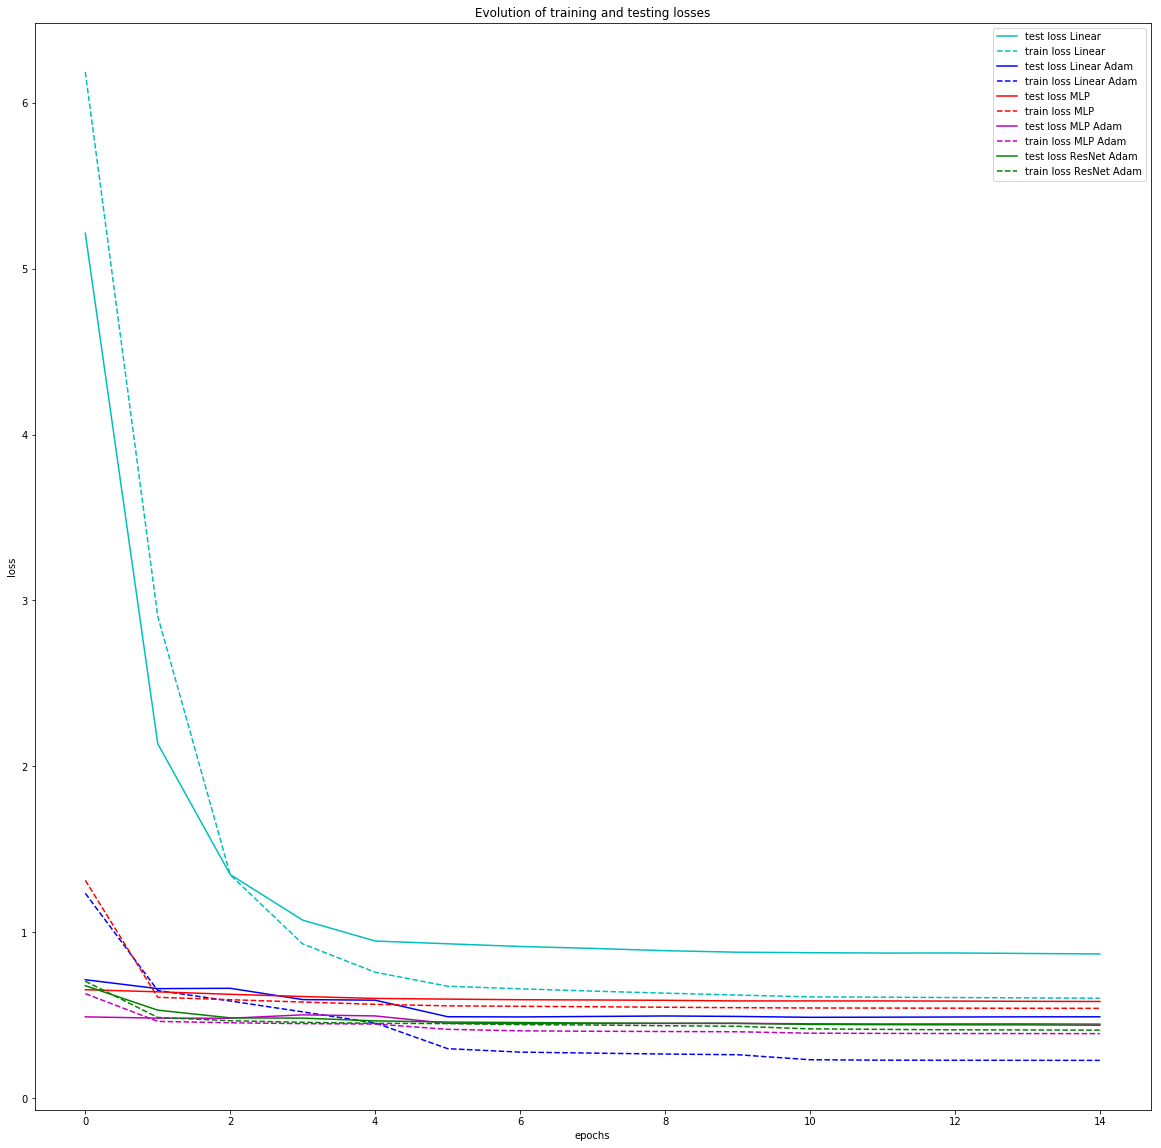

In [27]:
plt.figure(figsize=(20,20))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Evolution of training and testing losses')
x = range(15)
h1,  = plt.plot(x, test_1, 'c', label='test loss Linear')
h2,  = plt.plot(x, train_1, 'c--', label='train loss Linear')
h3,  = plt.plot(x, test_1a, 'b', label='test loss Linear Adam')
h4,  = plt.plot(x, train_1a, 'b--', label='train loss Linear Adam')
h5,  = plt.plot(x, test_2, 'r', label='test loss MLP')
h6,  = plt.plot(x, train_2, 'r--', label='train loss MLP')
h7,  = plt.plot(x, test_2a, 'm', label='test loss MLP Adam')
h8,  = plt.plot(x, train_2a, 'm--', label='train loss MLP Adam')
h9,  = plt.plot(x, test_3a, 'g', label='test loss ResNet Adam')
h10, = plt.plot(x, train_3a, 'g--', label='train loss ResNet Adam')
l   = plt.legend(handles=[h1, h2, h3, h4, h5, h6, h7, h8, h9, h10])

## Acknowledgement

This tutorial is inspired by some examples from [xlvector/github](https://github.com/xlvector/).